In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

In [2]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-2/main/listings.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,NaN,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.48
1,40625,https://www.airbnb.com/rooms/40625,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.85 · 2 bedrooms · 4...,NaN,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.59,4.72,NaN,t,15,14,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,NaN,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.59,NaN,f,3,3,0,0,2.36
3,70637,https://www.airbnb.com/rooms/70637,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.75
4,75500,https://www.airbnb.com/rooms/75500,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.45 · 2 bedrooms · 2...,NaN,NaN,https://a0.muscache.com/pictures/549090/b51ce4...,400857,...,4.67,4.08,4.42,NaN,f,1,1,0,0,0.08


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            14697 non-null  int64  
 1   listing_url                                   14697 non-null  object 
 2   scrape_id                                     14697 non-null  int64  
 3   last_scraped                                  14697 non-null  object 
 4   source                                        14697 non-null  object 
 5   name                                          14697 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         7553 non-null   object 
 8   picture_url                                   14697 non-null  object 
 9   host_id                                       14697 non-null 

# Cleaning

In [5]:
# host_location may contain values, which are outside of Vienna, even Austria!!!

data["In_Austria"] = data["host_location"].str.contains("Vienna, Austria")
data = data.loc[data["In_Austria"] == True]
print(data["host_location"].value_counts())

# Replace NA values

data.fillna(0, inplace=True)

# Replace currency price to float
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)


#Flags

# Has review (more than 0)
data["flag_number_of_reviews"] = data["number_of_reviews"] > 0
print(data["flag_number_of_reviews"].value_counts())

# Has a score of at least 3.5
data["flag_review_scores_rating"] = (data["review_scores_rating"] >= 3.5)
print(data["flag_review_scores_rating"].value_counts())

# Replace booleans to 1/0, so the program will be able to use it

def todummy(b):
    if b == True:
        return 1
    return 0

data["host_is_superhost"] = data["host_is_superhost"].apply(todummy)
data["host_has_profile_pic"] = data["host_has_profile_pic"].apply(todummy)
data["host_identity_verified"] = data["host_identity_verified"].apply(todummy)
data["instant_bookable"] = data["instant_bookable"].apply(todummy)

host_location
Vienna, Austria    9561
Name: count, dtype: int64
flag_number_of_reviews
True     8234
False    1327
Name: count, dtype: int64
flag_review_scores_rating
True     8126
False    1435
Name: count, dtype: int64


# 3 Different models:
- Linear OLS regression
- LASSO
- Random Forest

In [6]:
#train and test data
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((6692, 78), (2869, 78))

# OLS

# LASSO

# Random Forest

In [7]:
# basic variables
basic_vars = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
    "minimum_nights",
    "maximum_nights",
]

# reviews
reviews = [
    "number_of_reviews",
    "flag_number_of_reviews",
    "review_scores_rating",
    "flag_review_scores_rating",
]

# host dummy variables + instant_bookable
host = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:instant_bookable",
    "minimum_nights:property_type",
    "maximum_nights:property_type",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host
predictors_E = basic_vars + reviews + host + X1 + X2

In [9]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [11]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 10.15.


In [12]:
rfr = RandomForestRegressor(random_state = 20240129)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

%%time
rf_model = rf_random.fit(X, y.ravel())

In [14]:
rf_model.cv_results_

{'mean_fit_time': array([0.4378551 , 0.34389877, 0.31576481, 0.54237142, 0.43656793,
        0.38564458, 0.66645637, 0.52254872, 0.47475123, 0.76362243,
        0.585637  , 0.526054  ]),
 'std_fit_time': array([0.00467942, 0.00879711, 0.00722433, 0.00834638, 0.01610878,
        0.01663958, 0.03706161, 0.01180144, 0.02823596, 0.02039034,
        0.00405403, 0.01398819]),
 'mean_score_time': array([0.01719718, 0.01456523, 0.01296825, 0.0176116 , 0.01541123,
        0.01434913, 0.01856327, 0.01634245, 0.01565742, 0.01984057,
        0.01689935, 0.01647787]),
 'std_score_time': array([0.0021085 , 0.00049137, 0.00063069, 0.00093684, 0.00069765,
        0.00079381, 0.00079754, 0.0004867 , 0.00061393, 0.00100765,
        0.00060745, 0.00120398]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [15]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results

In [18]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,100.79,102.84,103.97
8,99.40,101.29,102.26
10,98.50,100.32,101.27
12,98.14,99.91,100.84


In [53]:
print("Best Score:",rf_model.best_score_)
print("Best Parameters:",rf_model.best_params_)
rf_model.best_estimator_

Best Score: -98.135161098091
Best Parameters: {'max_features': 12, 'min_samples_leaf': 5}


RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

## Diagnostic: Feature importances

In [22]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.87691065e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.42890121e-04,
       3.22414805e-04, 0.00000000e+00, 1.44159402e-02, 2.52197859e-02,
       0.00000000e+00, 1.76721035e-04, 0.00000000e+00, 0.00000000e+00,
       1.87041015e-04, 0.00000000e+00, 1.61346814e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.49231450e-04, 2.28815691e-04,
       6.31464125e-03, 3.72304132e-05, 5.84394856e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.19550485e-04,
       2.51055738e-02, 1.52817582e-03, 1.82735301e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.99907898e-05, 7.55150355e-04,
       0.00000000e+00, 7.01011174e-04, 1.09368740e-04, 1.98478434e-04,
       3.58636559e-02, 1.88737005e-03, 0.00000000e+00, 3.30071365e-02,
       4.08001050e-03, 1.26285142e-02, 1.80148065e-02, 5.32664508e-03,
       3.14013080e-02, 3.18964808e-04, 1.50829373e-02, 2.42728366e-04,
      

In [23]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire cabin],0.000000
property_type[T.Entire chalet],0.000000
property_type[T.Entire condo],0.002877
property_type[T.Entire cottage],0.000000
...,...
review_scores_rating,0.047330
host_is_superhost,0.000000
host_has_profile_pic,0.000000
host_identity_verified,0.000000


In [24]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

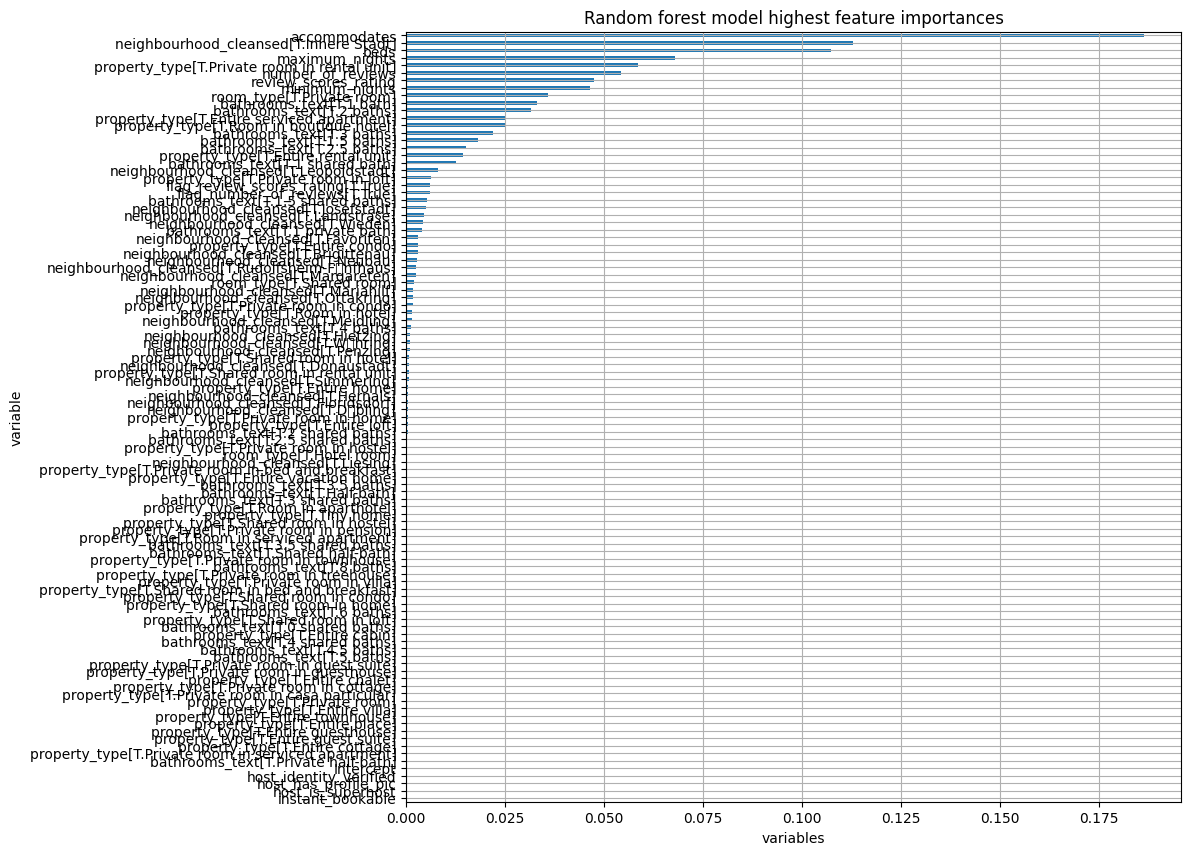

In [26]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

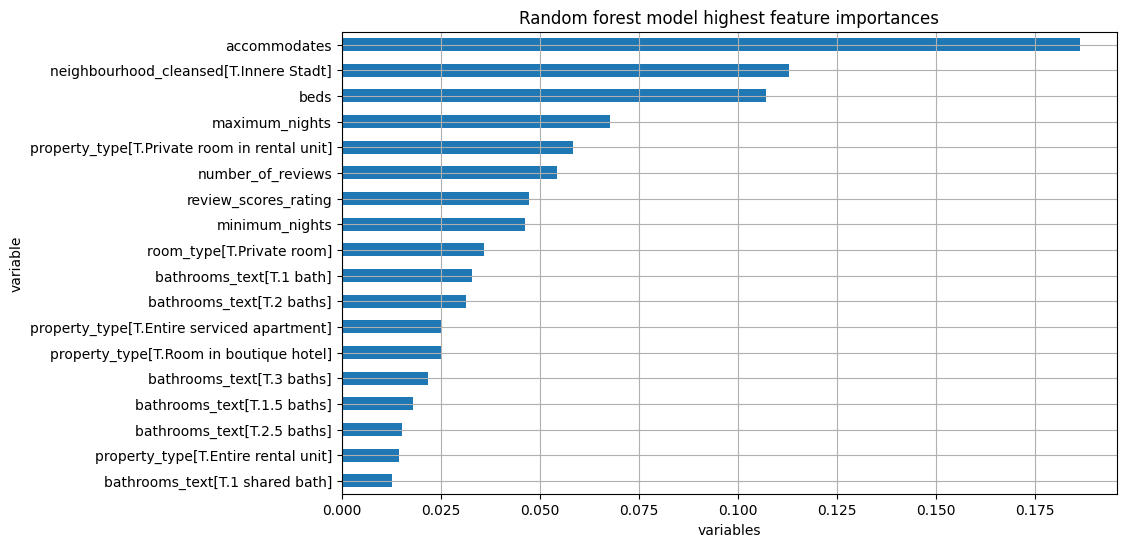

In [28]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [29]:
categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [31]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 2.55 s
Wall time: 2.55 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bathrooms_text',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'number_of_reviews',
                                                   'flag_number_of_reviews',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'instant_bookable'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [32]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 8.16 s
Wall time: 8.3 s


In [33]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.037628
beds,0.012583
property_type,0.034314
room_type,0.021956
bathrooms_text,0.025868
neighbourhood_cleansed,0.040798
minimum_nights,0.007434
maximum_nights,0.007881
number_of_reviews,0.004461
flag_number_of_reviews,0.000499


In [35]:
grouped = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
    "minimum_nights",
    "maximum_nights",
]

df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,4.1%,4.1%
1,accommodates,3.8%,7.8%
2,property_type,3.4%,11.3%
3,bathrooms_text,2.6%,13.9%
4,room_type,2.2%,16.1%
5,beds,1.3%,17.3%
6,maximum_nights,0.8%,18.1%
7,minimum_nights,0.7%,18.8%


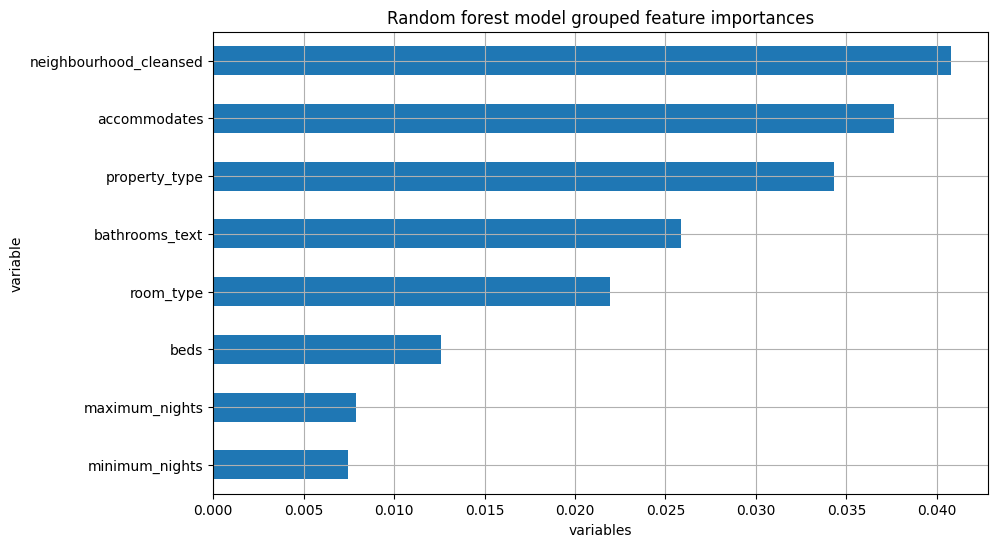

In [36]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [37]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,0.040798,0.186391
1,accommodates,0.037628,0.299291
2,property_type,0.034314,0.406541
3,bathrooms_text,0.025868,0.474362
4,room_type,0.021956,0.532801
5,beds,0.012583,0.587032
6,maximum_nights,0.007881,0.634362
7,minimum_nights,0.007434,0.680662
8,number_of_reviews,0.004461,0.716526
9,review_scores_rating,0.001788,0.749533


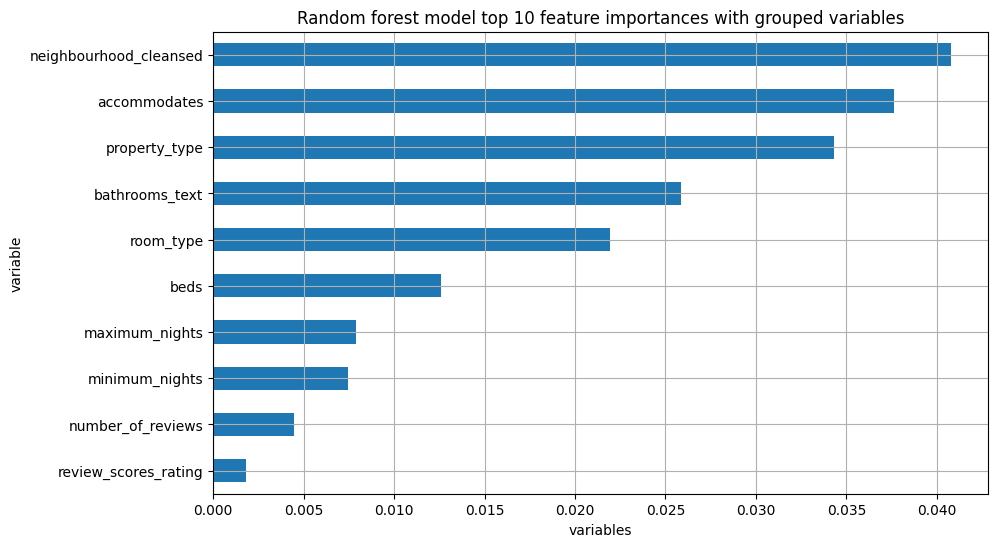

In [38]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

In [41]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

accomodates_pdp

{'grid_values': [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16],
        dtype=int64)],
 'values': [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16],
        dtype=int64)],
 'average': array([[ 84.56983004,  86.30293651,  88.19517752,  98.17885494,
         102.69488314, 129.90161522, 130.34796317, 149.99566161,
         151.44399411, 173.21368627, 171.69006235, 176.64003239,
         179.91628068, 204.40254204]])}

In [42]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,1,84.569830
1,2,86.302937
2,3,88.195178
3,4,98.178855
4,5,102.694883
5,6,129.901615
6,7,130.347963
7,8,149.995662
8,9,151.443994
9,10,173.213686


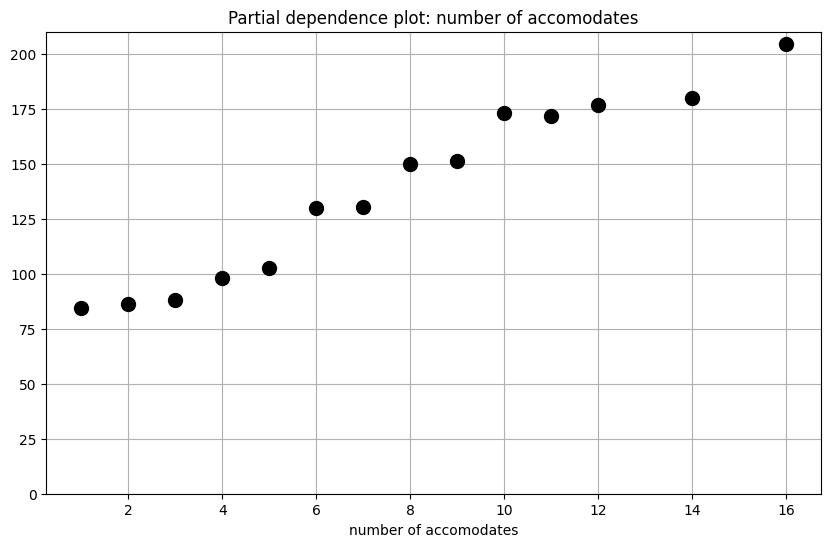

In [44]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: number of accomodates'
);

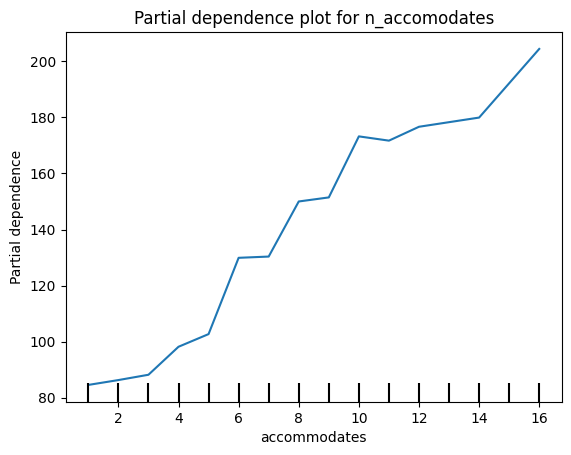

In [47]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 16, num=16)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

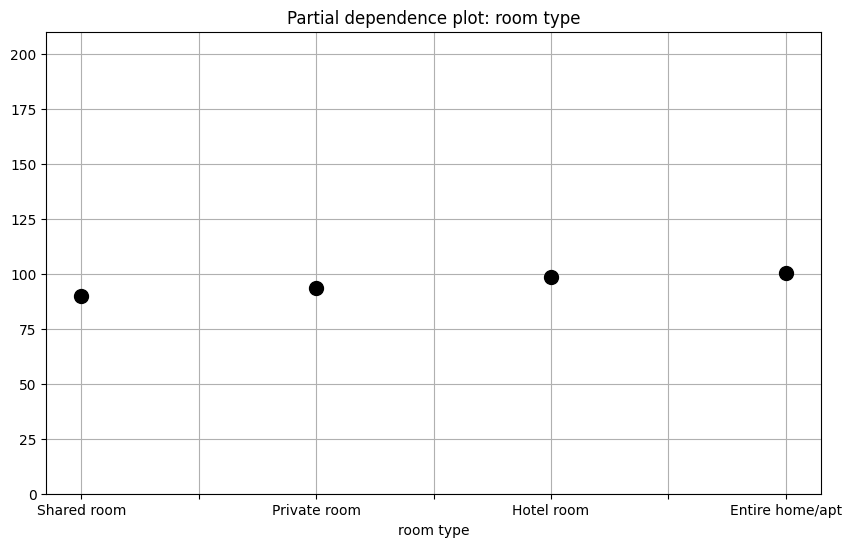

In [48]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["room_type"], kind="average"
)

pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: room type'
);